# Classifying Authors

Trying to classify which blogger wrote a provided post.

Dataset from http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm

For the sake of this assignment, we'll use the top 10 largest blog files where the profession is Engineering. This should give us plenty of data to work with, and should be more difficult to differentiate between that a mix of industries. The guess is that Engineers will use pretty similar vocab, making the separations between authors less trivial.

The data is in XML form, which means we'll have to do some parsing before we can start working with our data...

In [1]:
import nltk
import spacy
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET
import multiprocessing as mp
import collections
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from lxml import etree
parser = etree.XMLParser(encoding="Latin-1", recover=True)

%matplotlib inline

In [2]:
folder_path = "data/blogs/"

In [3]:
file_ids = [
    "1662633.female.23.Engineering.Pisces.xml",
    "152151.female.23.Engineering.Libra.xml",
    "906582.female.25.Engineering.Taurus.xml",
    "644059.female.25.Engineering.Scorpio.xml",
    "1934430.male.25.Engineering.Capricorn.xml",
    "1852942.male.23.Engineering.Libra.xml",
    "2040365.male.26.Engineering.Capricorn.xml",
    "299143.female.23.Engineering.Cancer.xml",
    "3064468.female.24.Engineering.Libra.xml",
    "3533584.male.26.Engineering.Sagittarius.xml"
]

In [4]:
def blog_post_parser(name, blog):
    posts = blog.findall("./post")
    for post in posts:
        data = {}
        data["author_id"] = name
        data["text"] = post.text
        
        yield data

In [5]:
# load the first file
posts = []
for file_id in file_ids:
    with open("data/blogs/" + file_id, "r", encoding="Latin-1") as fstream:
        element_tree = ET.parse(fstream, parser=parser)
        # MARK: - id strip
        # strip the id from the filename and use that only
        user_id = file_id[:(file_id.find("."))]
        parsed_content = blog_post_parser(int(user_id), element_tree)
        posts.extend(parsed_content)

In [6]:
# create the text df we need to work with from here on out
df = pd.DataFrame(posts)

In [7]:
df["post_id"] = range(len(df))

In [8]:
df = df[["post_id", "author_id", "text"]]

In [9]:
df.head()

,post_id,author_id,text
0,0,1662633,\n\n\t \n this has been a long ass day. S...
1,1,1662633,\n\n\t \n So i only have one more final t...
2,2,1662633,\n\n\t \n i mean one more day in blooming...
3,3,1662633,\n\n\t \n Ok so this was the longest day ...
4,4,1662633,\n\n\t \n so i have 4 finals on wednesday...


## Data Preprocessing with SpaCy

The next few cells will clean up the dataset by removing puncuation, etc, and replacing the current dataset with a modified list of tokens

In [10]:
nlp = spacy.load("en")

In [11]:
def clean_text(texts):
    """Cleans a text and returns
    a list of valid tokens (not stop tokens, not punct, etc)
    
    
    Parameters
    ----------
    texts : list of str texts
        The input texts to be processed
    
    Returns
    -------
    tokens : list of spacy.Token objects
        The tokens that meet the correct criteria.
        i.e. are not stop words, are not spaces or punctuation.
    
    """
    tokens_list = []
    for index, doc in enumerate(nlp.pipe(texts, n_threads=mp.cpu_count())):
        tokens = []
        
        for token in doc:
            if not token.is_stop and not token.is_space and not token.is_punct:
                tokens.append(token)
        
        tokens_list.append(tokens)
    
    return tokens_list
    

In [12]:
# transform the dataframe using the above function
texts = df.text.tolist()
processed_tokens = clean_text(texts)

In [13]:
df["processed_tokens"] = processed_tokens

In [14]:
df.author_id.value_counts()

1662633    589
644059     535
152151     436
1852942    394
906582     343
299143     328
1934430    328
2040365    273
3533584    257
3064468    188
Name: author_id, dtype: int64

## Feature Creation: BoW

These next few cells will use a BoW approach to create a feature set we can use. We'll restrict the number of features to 2500, as we don't want our approach to take too long...

In [15]:
all_tokens = list(itertools.chain.from_iterable(df.processed_tokens.tolist()))
all_tokens = [str(token) for token in all_tokens]
most_common_words = [item[0] for item in collections.Counter(all_tokens).most_common(2500)]

In [16]:
common_words_rows = []

for index, token_doc in enumerate(df.processed_tokens.tolist()):
    
    row = collections.defaultdict(int)
    
    for token in token_doc:
        if str(token) in most_common_words:
            row[str(token)] += 1
    
    common_words_rows.append(row)


In [17]:
# create a dict vectorizer to create a df quickly
vectorizer = DictVectorizer(dtype=np.uint16, sparse=False)

matrix = vectorizer.fit_transform(common_words_rows)

column_labels = vectorizer.get_feature_names()

feature_df = pd.DataFrame(matrix, index=range(len(df)), columns=column_labels)

# fill NaN with 0
feature_df = feature_df.fillna(0)

In [18]:
feature_df.shape

(3671, 2500)

In [19]:
target_df = df["author_id"].astype("str")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(target_df)
target = le.transform(target_df)

In [20]:
from sklearn.preprocessing import normalize
X_train, X_test, y_train, y_test = train_test_split(normalize(feature_df), target, test_size=0.25, random_state=42)

## Modeling: Clustering

The next few cells will initialize various clustering models to see if we can predict which author wrote each text.

In [21]:
# helper function to plot silohette score
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_silhouette_graphs(model, X_train, y_train):
    
    cluster_labels = model.fit_predict(X_train)
    n_clusters = len(model.cluster_centers_)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])
    
    # get average silhouette score
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print("For n_clusters = {}, the average silhouette score is: {}".format(n_clusters, silhouette_avg))
    
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster `i` and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    # Labeling the clusters
    centers = model.cluster_centers_
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_train[:, 0], X_train[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    
    
    # 3rd Plot showing the cluster centers, with a color overlay of the actual labels
    ax3.scatter(X_train[:, 0], X_train[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=y_train, edgecolor='k')

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("The visualization of the real labeled data.")
    ax3.set_xlabel("Feature space for the 1st feature")
    ax3.set_ylabel("Feature space for the 2nd feature")
    
    

    plt.suptitle(("Silhouette analysis for clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
import seaborn as sns

### K-Means

For n_clusters = 10, the average silhouette score is: 0.4445582978856683


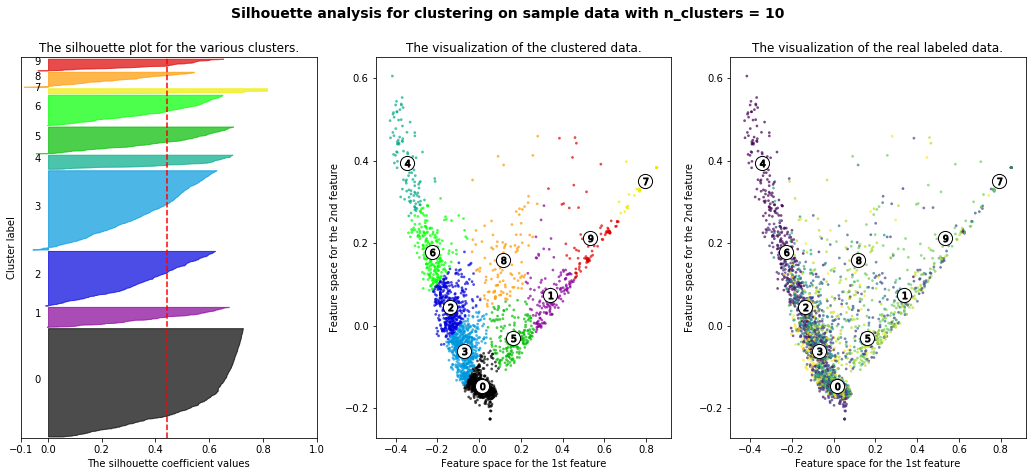

In [23]:
# downsample
X_train_pca = PCA(n_components=2).fit_transform(X_train)
X_test_pca = PCA(n_components=2).fit_transform(X_test)
kmeans_model = KMeans(n_clusters=10, random_state=42, n_jobs=-1)
plot_silhouette_graphs(kmeans_model, X_train_pca, y_train)

K-Means seems to be grouping together fairly well using PCA. But that does not mean that the clusters are mapping to our topics correctly.

### Mean Shift

For n_clusters = 2, the average silhouette score is: 0.4210793648379706


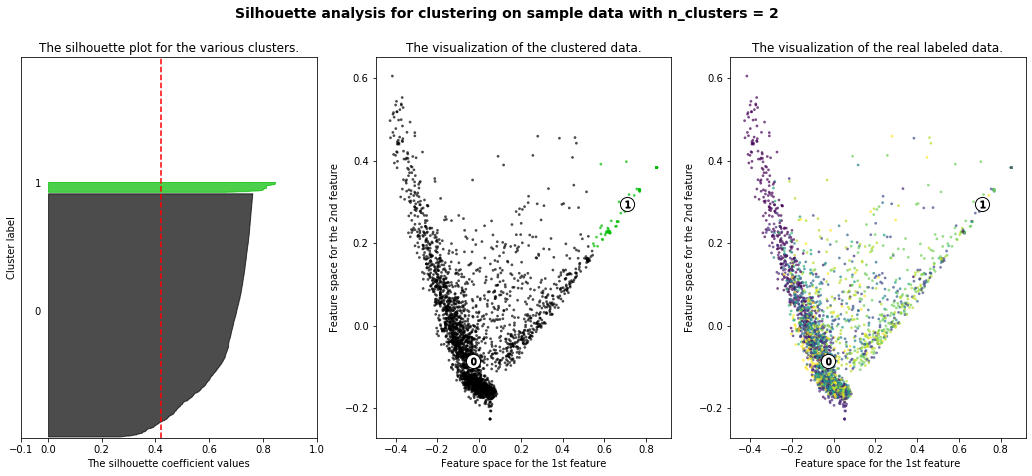

In [24]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift(cluster_all=False)

plot_silhouette_graphs(mean_shift, X_train_pca, y_train)

### Affinity Propagation

For n_clusters = 1026, the average silhouette score is: 0.17606321289133736


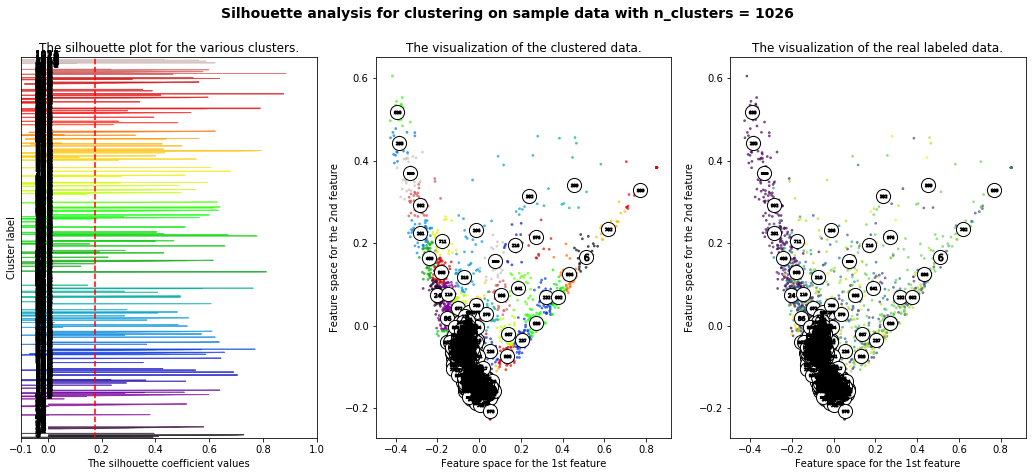

In [25]:
from sklearn.cluster import AffinityPropagation

affinity_prop = AffinityPropagation()
plot_silhouette_graphs(affinity_prop, X_train_pca, y_train)

### K-Means Classification

In [26]:
from sklearn.metrics import f1_score
# go through and find some different features using PCA
for component_count in range(2, 30):
    X_pca = PCA(n_components=component_count).fit_transform(X_train)
    k_means_classification = KMeans(n_clusters=10, n_jobs=-1)
    k_means_classification.fit(X_pca)
    
    # label prediction
    predictions = k_means_classification.predict(X_pca)
    
    score = adjusted_rand_score(y_train, predictions)
    fscore = f1_score(y_train, predictions, average="weighted")
    print("ARI Score for PCA(n_components={}) was: {}".format(component_count, score))
    print("F1 Score for PCA(n_components={}) was: {}".format(component_count, fscore))
    print("")

ARI Score for PCA(n_components=2) was: 0.06018370237596184
F1 Score for PCA(n_components=2) was: 0.04702930970789636

ARI Score for PCA(n_components=3) was: 0.06541428556126298
F1 Score for PCA(n_components=3) was: 0.12015383792232823

ARI Score for PCA(n_components=4) was: 0.0748006827536122
F1 Score for PCA(n_components=4) was: 0.08531473684190002

ARI Score for PCA(n_components=5) was: 0.0848873807202368
F1 Score for PCA(n_components=5) was: 0.062158819102923625

ARI Score for PCA(n_components=6) was: 0.08978436648299626
F1 Score for PCA(n_components=6) was: 0.05076050673543478

ARI Score for PCA(n_components=7) was: 0.08400256422730858
F1 Score for PCA(n_components=7) was: 0.07093063712403946

ARI Score for PCA(n_components=8) was: 0.09176367878008176
F1 Score for PCA(n_components=8) was: 0.12061348654429345

ARI Score for PCA(n_components=9) was: 0.08352073809140971
F1 Score for PCA(n_components=9) was: 0.06130514536882273

ARI Score for PCA(n_components=10) was: 0.083991929045951

## KNN Classification

In [27]:
from sklearn.neighbors import KNeighborsClassifier
for component_count in range(2, 30):
    X_pca = PCA(n_components=component_count).fit_transform(X_train)
    knn_classification = KNeighborsClassifier(n_jobs=-1)
    knn_classification.fit(X_pca, y_train)
    
    # label prediction
    predictions = knn_classification.predict(X_pca)
    
    score = adjusted_rand_score(y_train, predictions)
    fscore = f1_score(y_train, predictions, average="weighted")
    print("ARI Score for PCA(n_components={}) was: {}".format(component_count, score))
    print("F1 Score for PCA(n_components={}) was: {}".format(component_count, fscore))
    print("")

ARI Score for PCA(n_components=2) was: 0.20383483918528278
F1 Score for PCA(n_components=2) was: 0.4599839433264915

ARI Score for PCA(n_components=3) was: 0.22409405826053846
F1 Score for PCA(n_components=3) was: 0.4914762228563398

ARI Score for PCA(n_components=4) was: 0.2621434078759804
F1 Score for PCA(n_components=4) was: 0.5155842449268904

ARI Score for PCA(n_components=5) was: 0.2975190017320584
F1 Score for PCA(n_components=5) was: 0.5470113688341923

ARI Score for PCA(n_components=6) was: 0.3354066179001557
F1 Score for PCA(n_components=6) was: 0.5714429467634494

ARI Score for PCA(n_components=7) was: 0.3322195230565292
F1 Score for PCA(n_components=7) was: 0.5787895046767895

ARI Score for PCA(n_components=8) was: 0.3496411382059512
F1 Score for PCA(n_components=8) was: 0.5830988084402307

ARI Score for PCA(n_components=9) was: 0.3527666724368101
F1 Score for PCA(n_components=9) was: 0.584935623563686

ARI Score for PCA(n_components=10) was: 0.3408812312200908
F1 Score for

## Unsupervised Feature Selection

The clustering models seem to be doing pretty poorly across the board. K-Means cannot predict basically anything, and KNN is better, but not great. KNN is the best model yet, but let's see if we can improve upon that.

We'll use a restricted boltzmann machine to extract some features to use in subsequent models.

In [57]:
from sklearn.neural_network import BernoulliRBM

rbm_model = BernoulliRBM()
rbm_model.fit(X_train)

rbm_train_features = rbm_model.transform(X_train)

rbm_model = BernoulliRBM()
rbm_model.fit(X_test)

rbm_test_features = rbm_model.transform(X_test)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier

for train_features, test_features in [[rbm_train_features, rbm_test_features], [X_train, X_test]]:
    for model in [RandomForestClassifier(n_estimators=100), SVC(gamma="scale"), GradientBoostingClassifier(), RidgeClassifier()]:
        print(model.__class__.__name__)
        
        model.fit(train_features, y_train)
        
        predictions = model.predict(train_features)
        test_predictions = model.predict(test_features)
        
        print("Train F1 Score is: {}".format(f1_score(y_train, predictions, average="weighted")))
        print("Test F1 Score is: {}".format(f1_score(y_test, test_predictions, average="weighted")))
        print("-----------")
    print("==========================")

RandomForestClassifier
Train F1 Score is: 0.9892974579972994
Test F1 Score is: 0.014993720876073816
-----------
SVC


/Users/ryan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ryan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ryan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train F1 Score is: 0.18002585040270566
Test F1 Score is: 0.0572441590353815
-----------
GradientBoostingClassifier
Train F1 Score is: 0.9686333926396055
Test F1 Score is: 0.02181001066875338
-----------
RidgeClassifier
Train F1 Score is: 0.08767380235425255
Test F1 Score is: 0.03718614611032414
-----------
RandomForestClassifier


/Users/ryan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ryan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ryan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train F1 Score is: 0.9892981435509484
Test F1 Score is: 0.6985722170735674
-----------
SVC
Train F1 Score is: 0.9715481703148195
Test F1 Score is: 0.7123228720232287
-----------
GradientBoostingClassifier
Train F1 Score is: 0.9739755772369338
Test F1 Score is: 0.7221033511542385
-----------
RidgeClassifier
Train F1 Score is: 0.9639324636075125
Test F1 Score is: 0.7672073881785251
-----------


### Results

It seems like the raw BoW featureset on a classical prediction model like SVC or RandomForest did miles better than any clustering approach. The clustering approaches were extremely ambiguous. The lack of consistency in the clustering approach led to feature extraction using an RBM, which had a very good training score, but was **extremely** overfit to the training data. It turns out that the original BoW featureset I created had the best overall accuracy for both training and testing sets. The advantage of clustering would be more if we didn't know the labels but wanted to understand how things connected to each other. The RidgeClassifier had the best F1 scores for testing, making that the winning model. My guess is that because Ridge Regression is an L2 regularizer, that we do some automatic feature selection as to "de-noise" our featureset in training. That de-noising must help the overall fitness. The winning featureset was the original BoW feature set.

I could have used some additional methods like NNMF or LDA, but wanted to keep things simple.

Using RBM makes me want to continue investigation into auto-encoders and the like, in the future.